In [276]:
import pandas as pd
import numpy as np
import re
import nltk, spacy
import scipy.sparse as sp
from collections import Counter
from SimpleNLP import Tokenizer
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estadistica con palabras  

Al construir el vocabulario en una colección de documentos, se realizan  normalizaciones que nos permiten agrupar patrones comunes. aún cuando identificar y contabilizar los terminos en el vocabulario es útil para tareas simples, como computar estadisticas de uso o realizar búsquedas por palabras claves. Sin embargo, también se podría querer realizar tareas en la que la `importancia` dentro del documento o la colección de las palabras sea o no relevante. Por ejemplo no es deseado que un email  sea catalogado como spam solo una palabra común en ese tipo de mensajes.

Si se puede medir la importacia de los términos, también seá posible tan positivo o negativo es un tweet con respecto de otro en la mis colección. Los ejemplos anteriores los podemos modelar mediente el uso de la frecuencia con que aparece un termino un documento con respecto al resto en la colección. 

En las siguientes secciones ampliaremos el espacio vectorial binario mediate el uso de frecuencias, paa convertir las palabras en VSM de números reales. El objetivo es proporcionar un representación que capture la importacia de cada término.  

Las representaciones que revisaremos son:

- **Bolsa de palabras**. Representación basada en la fecuencia de  las palabras
- **Bolsa de $n$-gramas** Conteo de bigramas, trigramas, etc
- **TF-IDF** Permiten medir la importancia de las palabras.

**TF-IDF** es el acrónimo para `Term Frecuency Inverse Document Frecuency`. TF se refiere a la frecuencia de un  termino en un documento, mientras que IDF  implica que TF será pesado en base a la frecuencia de ese mismo termino en toda la colección (una división).

### Bolsa de palabras

En las sesiones previas ya hemos utilizado bolsas de palabras binarias, es decir solo decidimos si una palabra aparece o no en un documentos. A esta tipo en particular le denominamos **one-hot econding**. Con esa representación simple es posible crear un indice que permita hacer consultas simplmente utilizando operaciones `OR` y `AND`. Nuestro modulo `SimpleNLP` ya implementa ese tipo de datos.

Ahora procederemos a hacer una representación donde se considere el número de veces que aprece cada término en el documento. Es decir una bolsa de palabras que consideré la frecuencia.

In [173]:
# Carguemos nuevamente nuestro conjunto de tweets de humor
train_df=pd.read_csv('data/humor/train_english.tgz', compression='gzip',usecols=['is_humor','text'])
test_df=pd.read_csv('data/humor/dev_english.csv',usecols=['is_humor','text']) 
train_df=train_df.dropna().astype({'is_humor': 'int32'})
test_df=test_df.dropna().astype({'is_humor': 'int32'})

In [174]:
# Generemos nuestro vocabulario
from SimpleNLP import Tokenizer
# Entrenamos el modelo
tk=Tokenizer(derivador='stem')
tk.fit(train_df.text)

In [175]:
tk.vocabulario_index

array(['tennessee:', "we'r", 'the', ..., 'aspirin', '37%', 'e"'],
      dtype='<U79')

In [5]:
# Revisemos el tweet 50
tweet,label=train_df.iloc[100]
tweet_vector=tk.transform([tweet])

In [6]:
# Podemos ver su forma vectorial, texto, etiqueta y dimension
print(f"Vector:{tweet_vector.toarray()}\nTexto:{tweet}\nEtiqueta:{label}\nDimension{tweet_vector.shape}")

Vector:[[0 0 1 ... 0 0 0]]
Texto:Last night my wife and I watched 2 hours of cooking shows, before she hugged me and went to bed. I'm pretty sure I'm in the friend zone.
Etiqueta:1
Dimension(1, 22328)


In [7]:
# Elementos diferentes de 0 (VSM binario)
print(tweet_vector)

  (0, 2)	1
  (0, 20)	1
  (0, 29)	1
  (0, 51)	1
  (0, 59)	1
  (0, 63)	1
  (0, 65)	1
  (0, 75)	1
  (0, 76)	1
  (0, 359)	1
  (0, 361)	1
  (0, 385)	1
  (0, 609)	1
  (0, 675)	1
  (0, 698)	1
  (0, 872)	1
  (0, 910)	1
  (0, 1068)	1
  (0, 1069)	1
  (0, 1070)	1
  (0, 1071)	1
  (0, 1072)	1
  (0, 1073)	1
  (0, 1074)	1
  (0, 1075)	1
  (0, 1076)	1


Uno de los clasificadores que mejor funciona con este tipo de representaciones dispersas es SVM con kernel lineal. A continuación lo usaremos para tenerlo como referencia para comparar ambas versiones (Binario/Frecuencia). 

In [8]:
from sklearn.metrics import f1_score as f1, accuracy_score as acc
from sklearn.svm import LinearSVC
clf = LinearSVC()

In [176]:
# Transformamos los textos al VSM 
train=tk.transform(train_df.text)
test=tk.transform(test_df.text)

In [ ]:
# Entrenamos el clasificador
clf.fit(train,train_df.is_humor)

In [ ]:
y=test_df.is_humor
yp=clf.predict(test)
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

In [ ]:
# Podemos generar un mapa {"Palabra: count"} primero tokenizando
tweet_tokens=tk.tokenize(tweet)
Counter(tweet_tokens)

In [ ]:
# Utilizando el vocabulario_index es posible hacer la representación basada en frecuencia
N=len(tk.vocabulario_index)
C=[np.argwhere(tk.vocabulario_index==token)[0][0] for token in tweet_tokens if len(np.argwhere(tk.vocabulario_index==token))]
R=[0 for i in C]
X=[1 for i in C]
v=sp.csr_matrix((X,(R,C)), shape=(1,N))
print(v)

<div class="alert alert-success">
<b>Ejercicio</b>:<br />
    Agregar un metodo _tf_transform(corpus) que genere la bolsa de palabras considerando el número de veces que aparece cada token en un documento.
</div>

In [ ]:
# Transformamos los textos al VSM 
train_tf=tk._tf_transform(train_df.text)
test_tf=tk._tf_transform(test_df.text)

In [ ]:
clf2 = LinearSVC()
clf2.fit(train_tf,train_df.is_humor)
yp=clf.predict(test_tf)
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

Para documentos breves como el caso de los tweets, la bolsa de palabras contiene suficiente información sobre la intención de oración. Y esta información normalmente es suficiente para realizar tares como detectar spam, sentimiento (positividad, felicidad, humor, etc). Ahora clasifiquemos/ordenemos las palabras, esto nos ayudará a determinar cuales son más relevantes.

¿Como podemos determinar cuales son las más importantes?

In [216]:
# ¿Que obtnemos si ordemanos el vocabulario?
voc=list(tk.vocabulario.items())
voc.sort(reverse=True, key=lambda x: x[1])
voc_sort=[(tk.vocabulario_index[token],count) for token,count in voc]

In [ ]:
voc_sort[:5] # las cinco palabras mas comunes

In [ ]:
voc_sort[-5:] # las cinco palabras mas raras

Como ya mencionamos, el número de veces que aparece una palabra en un documento determinado se denomina frecuencia (TF). Podríamos normalizar la frecuencia dividiendo cada palabra por el número de términos en ella.

In [ ]:
#Número de terminos diferente de zero
len(train_tf[0].nonzero()[1])

In [ ]:
print(train_tf[0]/train_tf[0].sum())

In [ ]:
# Suma
np.sum(train_tf[0]/train_tf[0].sum())

### Espacios Vectoriales

La frecuencia de términos normalizados, es el recuento de palabras dividido por la longitud del documento. ¿Cuál es la razón para normalizar? Suponga que en un documento $A$ se encuentra la palabra "perro" 3 y 100 veces documento $B$. Con lo anterior se podria suponer que la palabra es más importante en B que en A. Pero espere que ocurre si el descubre A solo contiene 30 palabras  y el B 10000. Entoces tendríamos:

In [ ]:
importancia_perro_docA=3/100
importancia_perro_docB=100/10000

In [ ]:
print(importancia_perro_docA,importancia_perro_docB) # Entonces sería más relevante para A 

Dado que las palabras como "the", "and"  parecen no ser de utilidad removamolas. Agreguemos la lista de stop words a nuestro tokenizador.

In [5]:
#instanciamos un tokenizador con stop word removal
tk1=Tokenizer(derivador='stem',remove_stop_words=True)
tk1.fit(train_df.text)

In [6]:
print(len(tk.vocabulario_index),len(tk1.vocabulario_index))# un menor vocabulario

NameError: name 'tk' is not defined

In [7]:
voc1=list(tk1.vocabulario.items())
voc1.sort(reverse=True, key=lambda x: x[1])
voc1_sort=[(tk1.vocabulario_index[token],count) for token,count in voc1]

In [8]:
voc1_sort[:10] #las frecuencias son mucho menores

[('like', 684),
 ('get', 634),
 ("i'm", 541),
 ('me:', 514),
 ('peopl', 502),
 ('call', 495),
 ('one', 491),
 ('make', 435),
 ('say', 415),
 ('go', 408)]

In [314]:
train_s=tk1._tf_transform(train_df.text)
test_s=tk1._tf_transform(test_df.text)

In [315]:
# Podemos normalizar toda matriz como sigue
train_s_norm=sp.vstack([v/v.sum() for v in train_s])
test_s_norm=sp.vstack([v/v.sum() for v in test_s])

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/base.py:581: RuntimeWarning: divide by zero encountered in double_scalars
  return self.astype(np.float_)._mul_scalar(1./other)


Aún cuando *one-hot encoding* es un vector válido, este es disperso y no dice nada acerca de cómo se relacionan la palabras entre ellas. Desearíamos que el vector  pudiera expresar las similitudes y diferencias semánticas entre ellas, por ejemple si dos palabras significan lo mismo (son sinónimos), son términos opuestos (antónimos) o si en algún contexto podrían significar lo mismo. El ejemplo clásico utiliza las palabras **king**, **queen**, **woman**, **man** y asume que dado un embedding que capture las relaciones entre estas palabras debería cumplirse que:

$ \overrightarrow{king}-\overrightarrow{man}+\overrightarrow{woman}=\overrightarrow{queen}$

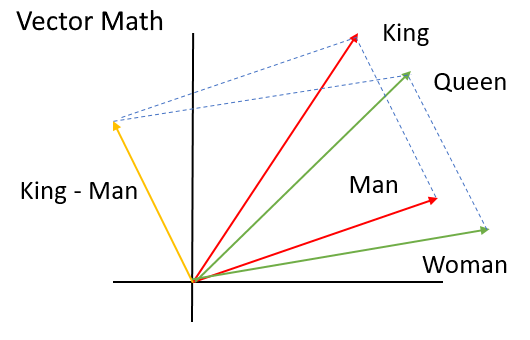

*fuente: https://blogs.mathworks.com/loren/2017/09/21/math-with-words-word-embeddings-with-matlab-and-text-analytics-toolbox/*|

Algunos ejemplos de relaciones que se podrían capturar serían por ejemplo que palabras como: *Paris, Teherán, Tokio, Canberra*  están relacionadas con la palabra capital, o *México, Estados Unidos, Canada* se relacionan con el término *Norte América*.  Por solo lo haremos mediante frecuencias, pero más adelante en el curso lo retomaremos mediane el uso de embeddings. 

Para un espacio vectorial de documentos, la dimensión de su espacio vectorial está dada por el tamaño del vocabulario $V$, es decir el número de palabras distintas en toda la colección de documentos. Por tanto la dimensión será $N=|V|$. Debido a la dificultad  de visualizar vectotres en de más de tres dimensiones, el hecho de que tanto TF como TF-IDF son vectores dispersos; se hace necesario proyectarlos mediante el uso de componenetes principales. Para nuestro caso usaremos la librería **TruncatedSVD**. 


In [317]:
from sklearn.decomposition import TruncatedSVD
tsvd=TruncatedSVD(100)
tsvd.fit(train_s_norm)
X=tsvd.transform(train_s_norm)

In [318]:
print(X[0])

[ 6.18456920e-03  1.11058148e-02 -4.43000081e-03 -1.14657485e-03
  6.81185711e-03 -5.10024346e-03  4.83165045e-03 -5.63921040e-03
  2.53875609e-03  1.44104574e-03  3.98893477e-03  2.61462276e-03
 -4.73708617e-05  1.29673814e-03  9.53897639e-04 -7.03362184e-03
 -9.26111523e-03  2.63519755e-03 -2.10539653e-03  1.10292137e-02
 -1.65055792e-03  8.92591710e-03  2.88227100e-03  8.00390124e-03
 -5.55374750e-04 -1.36035321e-02 -1.13244896e-03  2.12109677e-02
 -6.35010951e-03 -1.11107283e-02  5.44884031e-04  1.44579633e-03
  5.82451081e-03 -2.29805389e-03 -3.14154106e-02 -2.47202667e-03
  2.98186513e-02 -5.42270757e-03  4.18365983e-04  3.94259963e-02
 -8.85466292e-03 -2.26330314e-02 -8.55045005e-03 -2.58999709e-03
  3.63898401e-03  2.46457115e-02 -8.39060525e-03  8.38620930e-03
  1.33421154e-02 -3.69357992e-03 -1.18919580e-02 -5.39603933e-03
  2.91702573e-02  2.85371188e-03 -1.00474332e-02  2.08286934e-02
  1.54117394e-02 -9.09931706e-03  8.44096400e-03  4.19675151e-02
  3.60223649e-02 -9.21657

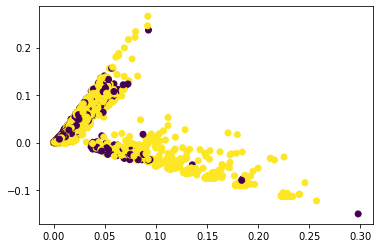

In [319]:
plt.scatter(X[:,0],X[:,1],c=train_df.is_humor);

In [320]:
import utilidades as ut

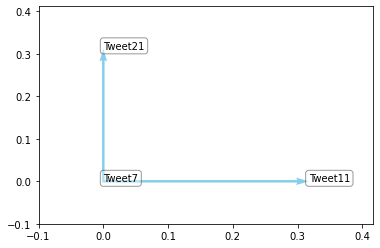

In [321]:
lista=[7,11,21]
ut.plotPCA(train_s_norm[lista],[f'Tweet{i}' for i in lista])

En un VMS, dod vectores son `similares` si tinen un ángulo similar. Opcionalmente, podría on no tener una magnitud similar. Una longitud similar implica frecuencias similares. Idealmente, nos gustaría que tanto el ángulo como la magnitud fueran aproximadamente iguales. Esto garantizaría que los documentos que representan cada vector probablemente traten de los mismo.

La similitud **coseno** es el coseno del ángulo ($\Theta$) entre dos vectores. Este puede ser calculado como el producto euclideano.

$$v_1 \cdot v_2= |v_1||v_2| \cos \Theta$$

$$\cos \Theta= \frac{v_1 \cdot v_2}{|v_1||v_2|}$$

La similitud de coseno toma valores entre 1 y -1, se calcula eficientemente utilizando el  producto escalar, y no requiere la evaluación de ninguna función trigonométrica.

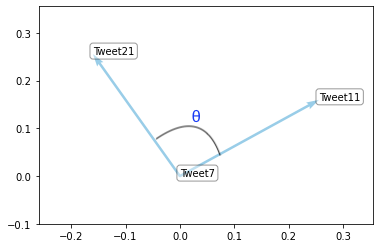

In [322]:
#Podemos definir la siguiente función
def coseno(x,y):
    sim=np.dot(x, y.T) / (np.linalg.norm(x) * np.linalg.norm(y))
    return sim

In [323]:
coseno(X[11,:],X[21,:])

0.011864793250908542

In [324]:
coseno(X[11,:],X[11,:])

0.9999999999999999

Una similitud de 1 representa vectores normalizados idénticos con el mismo ángulo en todas las direcciónes. Un valor de 0 representa dos vectores que no comparten componentes, es decir son ortogonales en todas las dimensiones. Una similitud de coseno de -1 representa dos vectores que apuntan en direcciones opuestas. Lo último no puede suceder para vectores simples de conteo de palabras (TF o TF-IDF).

## La ley de Zipf

Está basada en una regla que gobierna de forma más o menos general las estadisticas basadas en conteo. A principios del siglo XX, el taquígrafo francés Jean-Baptiste Estoup notó un patrón en la frecuencia de las palabras en muchos documentos. En la década de 1930, el lingüista estadounidense George Kingsley Zipf intentó formalizar la observación de Estoup, y esta  finalmente se constituyo como la ley de Zipf:

`La ley de Zipf establece que, dado corpus de documentos en lenguaje natural, la frecuencia de cualquier palabra esinversamente proporcional a su rango en la tabla de frecuencias.`

La situación de proporcionalidad inversa se refiere a que un elemento de una lista rankeada por frecuencia, cada palabra aparecerá con una frecuencia vinculada explícitamente a su rank en la lista. Es decir, el primer elemento de la lista aparecerá dos veces más que el segundo y tres veces más que el tercero, por ejemplo. 

¿Como podemos observar esa situación con el vocabulario?

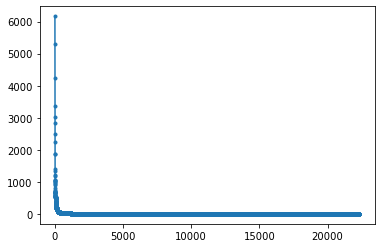

In [325]:
#Recordemos nuestro voc_sort
plt.plot([x[1] for x in voc_sort], marker='.')

Tracemos solo el top-100, top-20, top-10

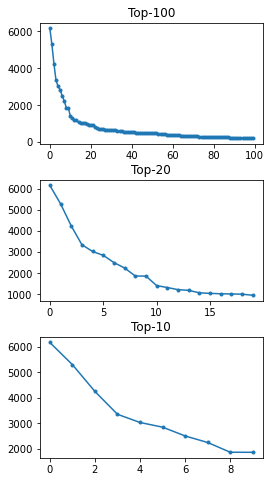

In [326]:
fig,axes=plt.subplots(3,1, figsize = (4,8))
for i,t in enumerate([100,20,10]): 
    axes[i].plot([x[1] for x in voc_sort[:t]], marker='.')
    axes[i].set_title(f"Top-{t}")
plt.subplots_adjust(hspace=0.3)

En resumen, si rankea las palabras de un corpus por el número de ocurrencias y las enumera en orden descendente, encontrará que, para una muestra lo suficientemente grande, la primera palabra en esa lista clasificada tiende tener el doble de probabilidades de aparecer que la del segundo lugar; es cuatro veces más probable que la cuarta palabra de la lista y así sucecivamente. Es posible concluir que dado un corpus grande, es posible inferir estadísticamente qué tan probable es que una palabra determinada aparezca en cualquier documento de ese corpus.

<div class="alert alert-success">
<b>Ejercicio</b>:<br />
   Gráfique la curva de Zipf para el corpus de Bronw disponible en la bilbiotec nltk. Utilice Counter del modulo collection
</div>

In [277]:
nltk.download('brown')
from nltk.corpus import brown
punctuation_table=ut.punctuation_table

[nltk_data] Downloading package brown to /Users/job/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [289]:
len(brown.words()) # Total de palabras no está

1161192

In [291]:
lista_de_palabras = (x.lower() for x in brown.words() if x not in punctuation_table)

### TF-IDF

Aun cuando el conteo de palabras es útil, por si solo no dice mucho sobre la importancia de cada palabra en el documento en relación con el resto de los documentos del corpus. Si pudiera descubrir esa información, podría comenzar a describir documentos de forma `global`  dentro del corpus. Suponga que tiene una colección de libros de historia. Es muy probable que la palabra `historia` ocurrirá muchas veces en cada libro (documento), dado que ya sabemos que son libros de historia, ese término no aporta información. Por otro lado términos como `lenguaje` o `electrónica` podrían no ser frecuentes en dentro del corpus, debido a lo anterior serían importantes para caracterizar esos documentos.

Para poder considerar la situción anterior, introduciremos el conceptos de frecuencia inversa de documentos (IDF), este concepto nos ayudará a aplicar Zipf para el análisis de los tópicos contenidos en un corpus. Note que tenemos dos tipos de frecuencia, está puede determinarse por documento o bien en todo el corpus.

En nuestro tokenizador ya hemos calculado las frecuencias para el copus en el diccionarion vocabulario:

In [327]:
tk1.vocabulario

{0: 2,
 1: 67,
 2: 144,
 3: 5,
 4: 25,
 5: 140,
 6: 179,
 7: 3,
 8: 1,
 9: 150,
 10: 3,
 11: 62,
 12: 1,
 13: 216,
 14: 1,
 15: 5,
 16: 1,
 17: 1,
 18: 1,
 19: 87,
 20: 30,
 21: 23,
 22: 6,
 23: 13,
 24: 1,
 25: 67,
 26: 2,
 27: 48,
 28: 8,
 29: 90,
 30: 6,
 31: 60,
 32: 26,
 33: 139,
 34: 81,
 35: 259,
 36: 72,
 37: 4,
 38: 7,
 39: 282,
 40: 46,
 41: 4,
 42: 175,
 43: 38,
 44: 50,
 45: 2,
 46: 34,
 47: 1,
 48: 41,
 49: 25,
 50: 12,
 51: 74,
 52: 541,
 53: 359,
 54: 21,
 55: 13,
 56: 1,
 57: 1,
 58: 9,
 59: 4,
 60: 320,
 61: 2,
 62: 16,
 63: 7,
 64: 10,
 65: 5,
 66: 1,
 67: 3,
 68: 85,
 69: 10,
 70: 5,
 71: 15,
 72: 1,
 73: 132,
 74: 1,
 75: 3,
 76: 7,
 77: 20,
 78: 16,
 79: 1,
 80: 21,
 81: 16,
 82: 10,
 83: 11,
 84: 1,
 85: 1,
 86: 230,
 87: 1,
 88: 4,
 89: 2,
 90: 2,
 91: 47,
 92: 25,
 93: 14,
 94: 514,
 95: 1,
 96: 19,
 97: 491,
 98: 2,
 99: 5,
 100: 23,
 101: 101,
 102: 1,
 103: 6,
 104: 6,
 105: 3,
 106: 9,
 107: 14,
 108: 7,
 109: 18,
 110: 20,
 111: 11,
 112: 5,
 113: 52,
 114:

y las rankeamos en voc1_sort

In [328]:
voc1_sort[:5]

[('like', 684), ('get', 634), ("i'm", 541), ('me:', 514), ('peopl', 502)]

In [329]:
# Tambien tenemos las frecuencias normalizadas (TF)
print(train_s_norm[0])

  (0, 0)	0.14285714285714285
  (0, 1)	0.07142857142857142
  (0, 2)	0.07142857142857142
  (0, 3)	0.07142857142857142
  (0, 4)	0.07142857142857142
  (0, 5)	0.07142857142857142
  (0, 6)	0.07142857142857142
  (0, 7)	0.07142857142857142
  (0, 8)	0.07142857142857142
  (0, 9)	0.07142857142857142
  (0, 10)	0.07142857142857142
  (0, 11)	0.07142857142857142
  (0, 12)	0.07142857142857142


El término IDF se calcula simplemente como la relación entre el número total de documentos y el número de documentos en los que aparece el término. Por ejemplo considere los siguientes casos:

- Suponga que palabra `like` aparece en 684 de los 8000 documentos entonce su IDF=684/800
- Si la palabre `me` aparece en 502 documento, entonces IDF=502/8000 

Finalmente se pude calcular TF-IDF como la multiplicación de sus vectores TF e IDF

In [332]:
print(train_s[0])

  (0, 0)	2
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1


¿Como podemos calcular TF-IDF para cada documento?